In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image

def visualize_output(image, boxes, keypoints):
    """
    Visualize the output model on the input image.

    Parameters:
    image (numpy.ndarray): The original image.
    boxes (numpy.ndarray): Array of bounding boxes, each box is [x, y, width, height].
    keypoints (numpy.ndarray): Array of keypoints for pose estimation.
    """

    result_image = image.copy()
    
    # Font setting for the numbers
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    
    # Draw bounding boxes
    for i, box in enumerate(boxes):
        center_x, center_y, width, height = box
        top_left_x = int(center_x - width / 2)
        top_left_y = int(center_y - height / 2)
        bottom_right_x = int(top_left_x + width)
        bottom_right_y = int(top_left_y + height)

        # Draw the box
        #cv2.rectangle(result_image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 2)
        
        # # Write the number of the box
        # text = str(i)
        # (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, font_thickness)
        # text_offset_x = top_left_x + text_width
        # text_offset_y = top_left_y + text_height
        # box_coords = ((text_offset_x, text_offset_y - text_height), (top_left_x, text_offset_y + 4))
        # cv2.rectangle(result_image, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
        # cv2.putText(result_image, text, (top_left_x, text_offset_y), font, font_scale, (0, 0, 255), font_thickness)

    # Draw keypoints
    for keypoint in keypoints:
        for x, y in keypoint:
            cv2.circle(result_image, (int(x), int(y)), 4, (255, 0, 0), -1)
    
    return result_image

def plot_results(image, mode="inline", scale=1):
    """
    Displays an image using either a popup window or inline display.

    Parameters
    ----------
    image : numpy.ndarray or CV2 image
        The image to display.
    mode : str, optional
        The display mode. Must be either "popup" or "inline". If "popup", the image is displayed in a popup window. If "inline", the image is displayed inline in the notebook. Default is "inline".
    scale : float, optional
        The scaling factor for the image. Default is 1.

    Raises
    ------
    ValueError
        If the mode is not "popup" or "inline".
    """
    
    if mode == "popup":
        pass
    elif mode == "inline":
        if type(image) == np.ndarray:
            # Convert from BGR to RGB (because OpenCV uses BGR order for color channels, whereas PIL uses RGB.)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image_rgb)
    else:
        raise ValueError("Mode must be either 'popup' or 'inline'")

    if type(image) is np.ndarray:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        width, height = image.size
        display(image.resize((int(width*scale), int(height*scale))))

In [2]:
model = YOLO('yolov8n-pose.pt')

100%|██████████| 6.51M/6.51M [00:00<00:00, 12.1MB/s]


In [3]:
# Predict with the model
image = cv2.imread('green.jpg')

results = model(image)

boxes = results[0].boxes.xywh  # Boxes object for bbox outputs
keypoints = results[0].keypoints.xy  # Keypoints object for pose outputs



0: 640x480 4 persons, 73.3ms
Speed: 3.0ms preprocess, 73.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


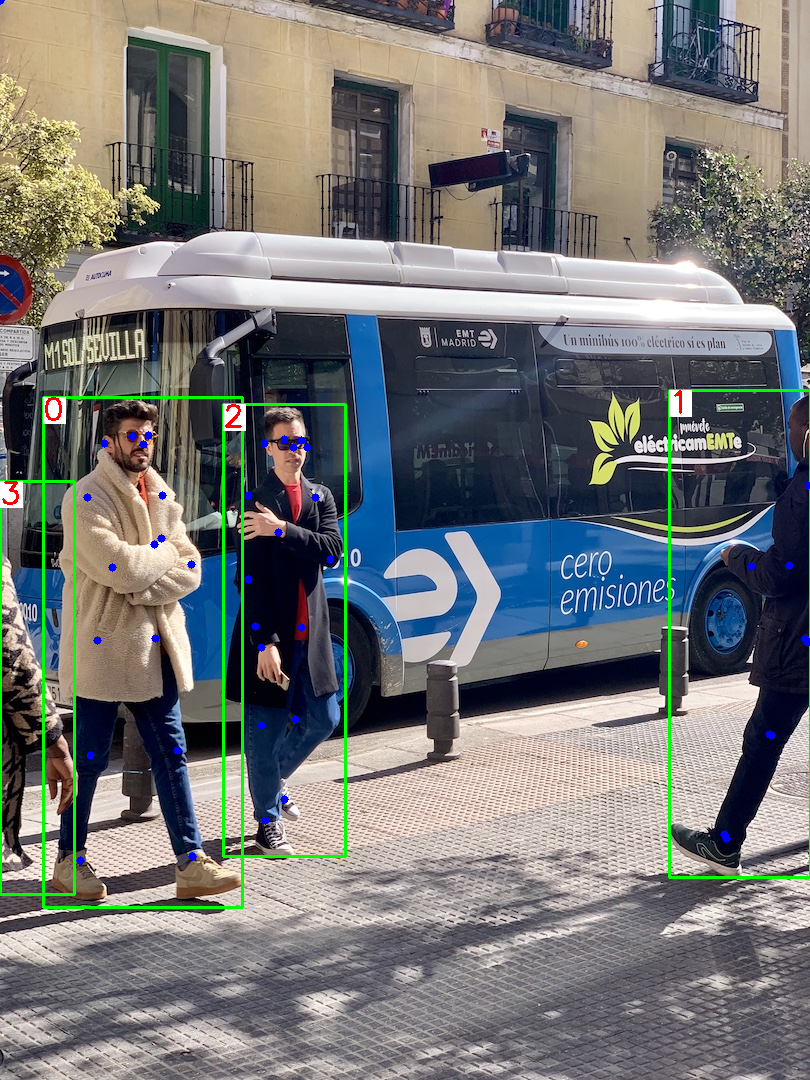

In [147]:
result = visualize_output(image, boxes, keypoints)
plot_results(result)